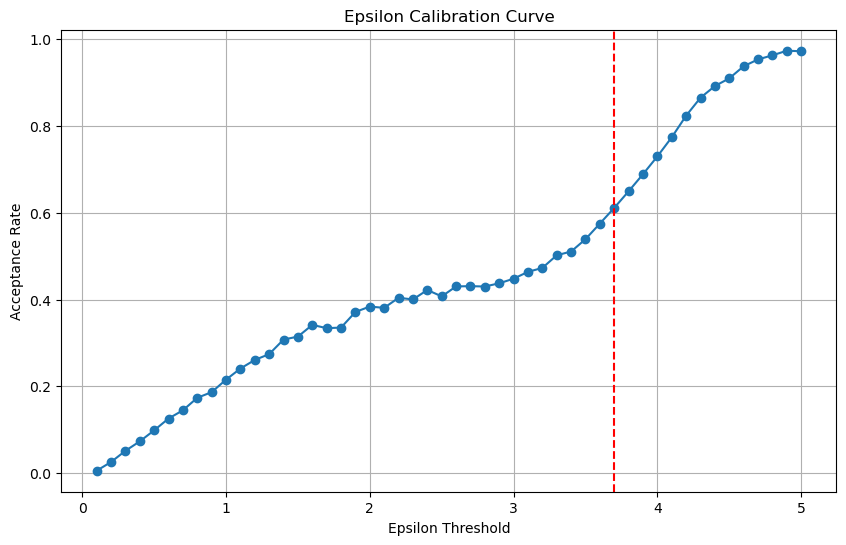

Calibrated epsilon: 3.7000

Model Performance Summary:
- Quadratic: RMSE = 0.0176 (Weight = 0.812)
- Exponential: RMSE = 0.0385 (Weight = 0.181)
- Hyperbolic: RMSE = 2.6124 (Weight = 0.004)
- Logarithmic: RMSE = 2.9217 (Weight = 0.003)

Weighted Ensemble RMSE: 0.0334
Predicted Best Model: Quadratic
Actual Best Model: Quadratic


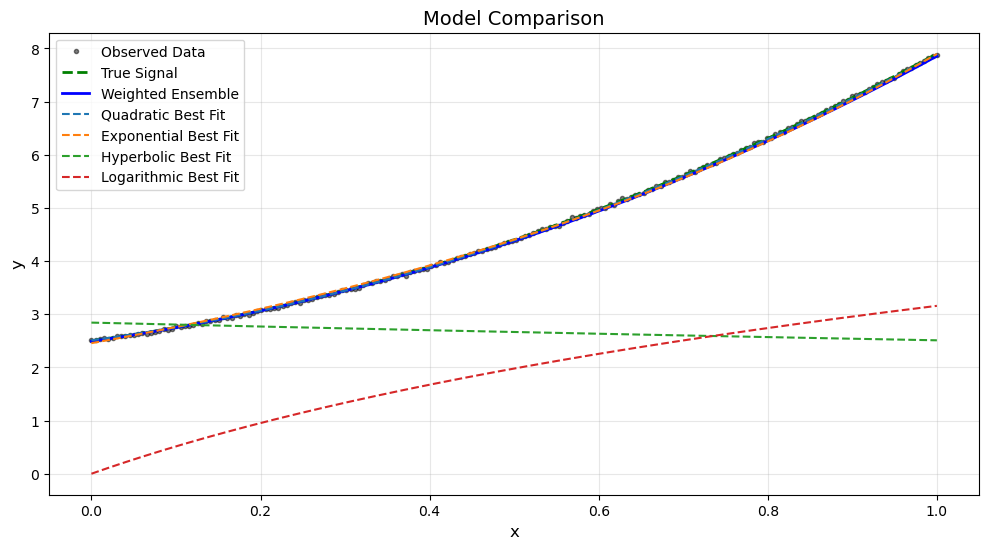


Quadratic Model Posterior Summary:


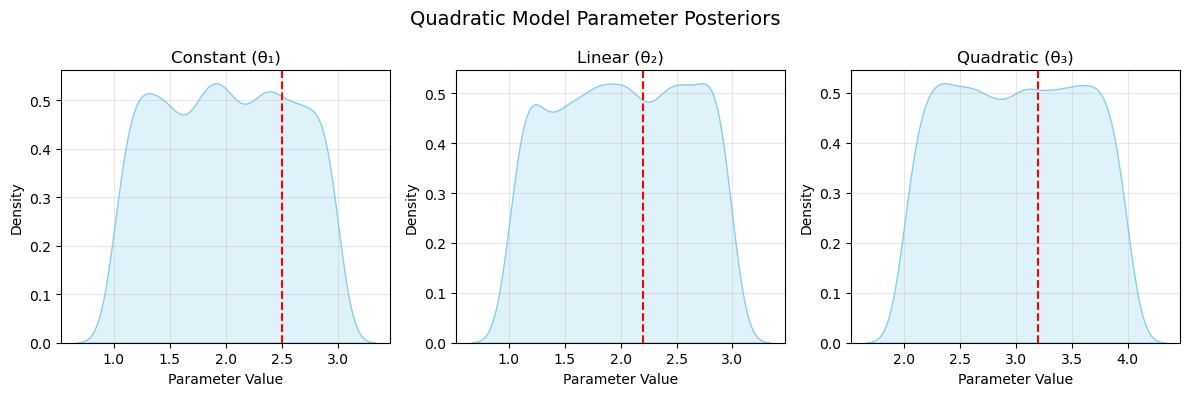

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns

np.random.seed(42)

true_coeffs = [2.5, 2.2, 3.2]
n = 200
x = np.linspace(0, 1, n)

def quadratic(x, coeffs):
    return coeffs[0] + coeffs[1] * x + coeffs[2] * x**2

true_signal = quadratic(x, true_coeffs)
noise = 0.01 * np.std(true_signal) * np.random.randn(n)
y_obs = true_signal + noise

def model_quadratic(x, theta):
    return theta[0] + theta[1] * x + theta[2] * x**2

def model_exponential(x, theta):
    a, b = theta
    return a * np.exp(b * x)

def model_hyperbolic(x, theta):
    a, b = theta
    return a / (b * x + 1)

def model_logarithmic(x, theta):
    a, b = theta
    return a * np.log(b * x + 1)

models = {
    1: {"name": "Quadratic", "func": model_quadratic, "dim": 3,
        "prior": [(1, 3), (1, 3), (2, 4)]},
    2: {"name": "Exponential", "func": model_exponential, "dim": 2,
        "prior": [(1.0, 3.0), (0.5, 2.5)]},
    3: {"name": "Hyperbolic", "func": model_hyperbolic, "dim": 2,
        "prior": [(1.0, 3.0), (0.1, 2.0)]},
    4: {"name": "Logarithmic", "func": model_logarithmic, "dim": 2,
        "prior": [(1.0, 3.0), (0.1, 2.0)]}
}

def calibrate_epsilon(y_obs, models, x, n_samples=5000):
    epsilons = np.linspace(0.1, 5, 50)
    acceptance_rates = []
    for eps in epsilons:
        accepted = 0
        for _ in range(n_samples):
            model_id = np.random.choice(list(models.keys()))
            model = models[model_id]
            theta = [np.random.uniform(low, high) for (low, high) in model["prior"]]
            y_sim = model["func"](x, theta)
            dist = np.sqrt(mean_squared_error(y_obs, y_sim))
            if dist < eps:
                accepted += 1
        acceptance_rates.append(accepted / n_samples)

    best_idx = np.argmin(np.abs(np.array(acceptance_rates) - 0.60))
    best_eps = epsilons[best_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(epsilons, acceptance_rates, marker='o')
    plt.axvline(best_eps, color='r', linestyle='--')
    plt.title("Epsilon Calibration Curve")
    plt.xlabel("Epsilon Threshold")
    plt.ylabel("Acceptance Rate")
    plt.grid()
    plt.show()

    print(f"Calibrated epsilon: {best_eps:.4f}")
    return best_eps

def calculate_weights(perf, temp=0.5):
    scores = {}
    for mid, p in perf.items():
        if p["rmse"]:
            scores[mid] = np.exp(-np.median(p["rmse"]) / temp)
        else:
            scores[mid] = 0
    total = sum(scores.values())
    return {mid: (s / total if total > 0 else 1 / len(models)) for mid, s in scores.items()}

def abc_rjmcmc_adaptive(x, y_obs, models, epsilon, n_iter=5000, explore_frac=0.2):
    model_perf = {k: {"rmse": [], "params": []} for k in models}
    n_explore = int(n_iter * explore_frac)

    for i in range(n_iter):
        if i < n_explore:
            model_id = np.random.choice(list(models.keys()))
        else:
            weights = calculate_weights(model_perf)
            model_id = np.random.choice(list(weights.keys()), p=list(weights.values()))

        model = models[model_id]
        theta = [np.random.uniform(low, high) for (low, high) in model["prior"]]
        y_sim = model["func"](x, theta)
        dist = np.sqrt(mean_squared_error(y_obs, y_sim))

        if dist < epsilon:
            model_perf[model_id]["rmse"].append(dist)
            model_perf[model_id]["params"].append(theta)

    return model_perf

epsilon = calibrate_epsilon(y_obs, models, x)
model_performance = abc_rjmcmc_adaptive(x, y_obs, models, epsilon)

weights = calculate_weights(model_performance)
weighted_prediction = np.zeros_like(y_obs)
model_rmse = {}

for mid, perf in model_performance.items():
    name = models[mid]["name"]
    if not perf["params"]:
        model_rmse[name] = np.nan
        continue

    best_idx = np.argmin(perf["rmse"])
    best_theta = perf["params"][best_idx]
    pred = models[mid]["func"](x, best_theta)
    rmse = np.sqrt(mean_squared_error(y_obs, pred))
    model_rmse[name] = rmse
    weighted_prediction += weights[mid] * pred

weighted_rmse = np.sqrt(mean_squared_error(y_obs, weighted_prediction))
predicted_best = models[max(weights, key=weights.get)]["name"]
actual_best = min(model_rmse, key=lambda k: model_rmse[k] if not np.isnan(model_rmse[k]) else np.inf)

print("\nModel Performance Summary:")
for m, rmse in model_rmse.items():
    model_id = next((mid for mid, model in models.items() if model["name"] == m), None)
    weight = weights.get(model_id, 0) if model_id is not None else 0
    print(f"- {m}: RMSE = {rmse:.4f} (Weight = {weight:.3f})")

print(f"\nWeighted Ensemble RMSE: {weighted_rmse:.4f}")
print(f"Predicted Best Model: {predicted_best}")
print(f"Actual Best Model: {actual_best}")

plt.figure(figsize=(12, 6))
plt.plot(x, y_obs, 'k.', alpha=0.5, label='Observed Data')
plt.plot(x, true_signal, 'g--', linewidth=2, label='True Signal')
plt.plot(x, weighted_prediction, 'b-', linewidth=2, label='Weighted Ensemble')

for mid, perf in model_performance.items():
    if perf["params"]:
        best_theta = perf["params"][np.argmin(perf["rmse"])]
        plt.plot(x, models[mid]["func"](x, best_theta), '--',
                 label=f"{models[mid]['name']} Best Fit")

plt.title("Model Comparison", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

def plot_quadratic_posterior(perf, models):
    quad_perf = perf[1]
    params = np.array(quad_perf["params"])

    if params.size == 0:
        print("No accepted samples for quadratic model")
        return

    print("\nQuadratic Model Posterior Summary:")
    param_names = ['Constant (θ₁)', 'Linear (θ₂)', 'Quadratic (θ₃)']
    for i in range(3):
        mean_val = np.mean(params[:, i])
        median_val = np.median(params[:, i])

    plt.figure(figsize=(12, 4))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        sns.kdeplot(params[:, i], fill=True, color='skyblue')
        plt.axvline(true_coeffs[i], color='red', linestyle='--')
        plt.title(param_names[i])
        plt.xlabel('Parameter Value')
        plt.grid(alpha=0.3)
    plt.suptitle("Quadratic Model Parameter Posteriors", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_quadratic_posterior(model_performance, models)
